In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.measure

import random
import copy
import math
import cv2
import os
import sys

import argparse
import datetime
import json
import time
from pathlib import Path

import torch

import models_mae
import util.misc as misc
from engine_pretrain import train_one_epoch
from main_ViT import main, get_args_parser, run_one_image, DATASET_PATH, SemanticMapDataset
import timm.optim.optim_factory as optim_factory
from util.misc import NativeScalerWithGradNormCount as NativeScaler

/tmp/ipykernel_3378845/3958361844.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pred = torch.Tensor([0.7, 0.2, 0.1])
target = torch.Tensor([1, 0, 0])
loss = torch.nn.BCEWithLogitsLoss()(pred, target)
print(loss)
pred = torch.Tensor([1, 0, 0])
target = torch.Tensor([1, 0, 0])
loss = torch.nn.BCEWithLogitsLoss()(pred, target)
print(loss)

tensor(0.6486)
tensor(0.5665)


# TRAINED MODELS
## Variables definition

In [3]:
div = 32
step = int(32/4)
red = 3

# [15:39:05.085417] TRAINING MAPS: ['stanford_coupa0', 'stanford_coupa1', 'stanford_coupa2', 'stanford_hyang0', 'stanford_hyang1', 'stanford_hyang4', 'stanford_nexus0']

# [15:39:05.085432] VALIDATION MAPS: ['stanford_coupa3', 'stanford_gates2', 'stanford_hyang10', 'stanford_hyang2', 'stanford_hyang5', 'stanford_little3', 'stanford_nexus1']

# [15:39:05.085440] TEST MAP: ['stanford_hyang3']

# 10/2/2024
# [13:16:39.378390] TRAINING MAPS: ['stanford_coupa3', 'stanford_gates2', 'stanford_hyang0', 'stanford_hyang1', 'stanford_hyang10', 'stanford_hyang2', 'stanford_hyang3', 'stanford_hyang4', 'stanford_hyang5', 'stanford_little3', 'stanford_nexus0', 'stanford_nexus1']

# [13:16:39.378407] VALIDATION MAPS: ['stanford_coupa0', 'stanford_coupa1']

# [13:16:39.378414] TEST MAP: ['stanford_coupa2']

# 12/2/2024
# [13:34:25.977320] TRAINING MAPS: ['stanford_coupa0', 'stanford_coupa1', 'stanford_coupa2', 'stanford_coupa3', 'stanford_deathCircle0', 'stanford_hyang10', 'stanford_hyang3', 'stanford_hyang4', 'stanford_nexus0', 'stanford_nexus1']

# [13:34:25.977337] VALIDATION MAPS: ['stanford_gates2', 'stanford_hyang2', 'stanford_little3']

# [13:34:25.977344] TEST MAP: ['stanford_gates2', 'stanford_hyang2', 'stanford_little3']

map_list_t = ['master_big','master_big_closed','master_big_semiclosed']
map_root_name = 'master_big'
map_list = ['stanford_coupa0', 'stanford_coupa1', 'stanford_coupa2', 'stanford_coupa3', 'stanford_deathCircle0', 'stanford_gates2', 'stanford_hyang2', 'stanford_hyang3', 'stanford_hyang4', 'stanford_hyang10', 'stanford_little3', 'stanford_nexus0', 'stanford_nexus1']

sem_dict = ['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree','restricted','grass','intersection','shadow']
chans = len(sem_dict)+1

lut_in = [0, 10, 30, 50, 70, 110, 150, 255]
lut_out = [0, 120, 200, 225, 240, 248, 250, 255]
lut_in = [0, 10, 70, 150, 255]
lut_out = [0, 130, 210, 245, 255]
# plt.plot(lut_in, lut_out)
lut_8u = np.interp(np.arange(0, 256), lut_in, lut_out).astype(np.uint8)

# Loading of the models

In [4]:
# args = get_args_parser()
# args = args.parse_args()

# args.resume = '/home/placido.falqueto/IRI_Barcelona/mae/output_dir/test3-checkpoint-100.pth'

# device = torch.device(args.device)

# # define the model
# model = models_mae.__dict__[args.model](norm_pix_loss=args.norm_pix_loss)

# model.to(device)

# model_without_ddp = model

# eff_batch_size = args.batch_size * args.accum_iter * misc.get_world_size()

# if args.lr is None:  # only base_lr is specified
#     args.lr = args.blr * eff_batch_size / 256

# # following timm: set wd as 0 for bias and norm layers
# param_groups = optim_factory.add_weight_decay(model_without_ddp, args.weight_decay)
# optimizer = torch.optim.AdamW(param_groups, lr=args.lr, betas=(0.9, 0.95))
# loss_scaler = NativeScaler()

# misc.load_model(args=args, model_without_ddp=model_without_ddp, optimizer=optimizer, loss_scaler=loss_scaler)

## Testing closed corridors (completely or partially closed)

In [5]:
# red1 = 8

# for map_name in map_list_t:
#   print(map_name)

#   lines = 0
#   try:
#     with open('/home/placido.falqueto/IRI_Barcelona/maps/semantics/'+map_root_name+'/'+map_name+'-reduced.csv') as f:
#       print('Reduced map found')
#       lines = f.readlines()
      
#   except FileNotFoundError:
#     with open('/home/placido.falqueto/IRI_Barcelona/maps/semantics/'+map_root_name+'/'+map_name+'.csv') as f:
#       print('Using original map')
#       lines = f.readlines()

#   h = len(lines)
#   w = len(lines[0].split(','))

#   # Converts data to a list of integers
#   map = []
#   for line in lines:
#     map.extend([int(c) for c in line.split(',')])

#   for lab_class in sem_dict:
#     lines = 0
#     try:
#       with open('/home/placido.falqueto/IRI_Barcelona/maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'-reduced.csv') as f:
#         lines = f.readlines()

#       hh = len(lines)
#       ww = len(lines[0].split(','))

#       if hh != h or ww != w:
#         print(f'h: {h}\tw: {w}')
#         print(f'h: {hh}\tw: {ww}')
#         raise SystemExit("ERROR: Different sizes!!")

#       # Converts data to a list of integers
#       for line in lines:
#         map.extend([int(c) for c in line.split(',')])
    
#     except FileNotFoundError:
#       try:
#         with open('/home/placido.falqueto/IRI_Barcelona/maps/semantics/'+map_root_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
#           lines = f.readlines()

#         hh = len(lines)
#         ww = len(lines[0].split(','))

#         if hh != h or ww != w:
#           print(f'h: {h}\tw: {w}')
#           print(f'h: {hh}\tw: {ww}')
#           raise SystemExit("ERROR: Different sizes!!")

#         # Converts data to a list of integers
#         for line in lines:
#           map.extend([int(c) for c in line.split(',')])

#       except FileNotFoundError:
#         for i in range(h):
#           for j in range(w):
#             map.extend([255])

#   map = np.reshape(map,[chans,h,w])
#   map = np.moveaxis(map, 0, -1)
#   map = map/255

#   map_aux = map
#   map = np.zeros((int(math.ceil(h/red1)),int(math.ceil(w/red1)),chans))

#   for idx in range(chans):
#     map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red1,red1), np.max)

#   # print(map.shape)
#   h, w, _ = map.shape

#   lines = 0
#   with open('/home/placido.falqueto/IRI_Barcelona/maps/semantics/'+map_root_name+'/humandensity-'+map_root_name+'-new.csv') as f:
#     lines = f.readlines()

#   hd = len(lines)
#   wd = len(lines[0].split(','))

#   # Converts data to a list of integers
#   data = []
#   for line in lines:
#     data.extend([int(c) for c in line.split(',')])

#   data = np.reshape(data,[hd,wd])
  
#   sigma = 10.0
#   # data = skimage.filters.gaussian(data, sigma=(sigma, sigma), channel_axis=-1)
#   data = skimage.measure.block_reduce(data, (red1,red1), np.max)
#   # data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))
#   data = data*(map[:,:,0]>0)
  
#   lim_val = 0.15
#   sigma = 0.5
#   data_show = np.clip(data,0,np.max(data)*lim_val)/(np.max(data)*lim_val)
#   data_show = cv2.LUT((data_show*255).astype(np.uint8), lut_8u).astype(np.float32)/255
#   data_show = skimage.filters.gaussian(data_show, sigma=(sigma, sigma), channel_axis=-1)
#   data = data_show/np.sum(data_show)

#   # -----------------------------------------------------------------------------------
#   # Random sample 32x32 windows in map
#   n_crops = 100
#   inserted = 0
#   crops = np.zeros((n_crops,2),dtype=int)
#   selections = np.zeros((h,w))
#   for i in range(n_crops):
#     background = np.zeros((h,w))
#     flag = True
#     while flag:
#       aux_x = int(random.random()*(w-div+1))
#       aux_y = int(random.random()*(h-div+1))
#       flag = False
#       # print(f'INSERTED: {inserted}  ->  x: {aux_x} and y: {aux_y}')
#       # for z in range(inserted):
#       #   if abs(aux_x-crops[z,0])<int(div/10) and abs(aux_y-crops[z,1])<int(div/10):
#       #     # print('too close')
#       #     flag = True
#     crops[i,0] = aux_x
#     crops[i,1] = aux_y
#     selections = selections+cv2.rectangle(background,(crops[i,0],crops[i,1]),(crops[i,0]+div-1,crops[i,1]+div-1),(1,1,1),-1)
#     inserted = inserted + 1
#   selections = 1/selections

#   # -----------------------------------------------------------------------------------
#   # creating subplot and figure
#   ax = plt.subplot(111)
#   data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))
#   kls = []
#   for i in range(n_crops):
#     submap = map[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div,:]
#     data_aux = data[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
#     submap = torch.tensor(np.expand_dims(submap,axis=0), dtype=torch.float32).to(device)
#     _, subdata, _ = model(submap)
#     subdata = torch.einsum('nchw->nhwc', subdata).detach().cpu()
#     subdata = subdata.squeeze(dim=0).squeeze(dim=2).numpy()
#     data_pred[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    
#   data = torch.Tensor(data)
#   data_pred = torch.Tensor(data_pred)
#   data = data/data.max()
#   data_pred = data_pred/data_pred.max()
  
#   data_pred = data_pred/np.max(data_pred.detach().cpu().numpy())
#   plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
#   # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)
#   plt.show()

## Model 1 testing

stanford_coupa0
Resume checkpoint /home/placido.falqueto/IRI_Barcelona/mae/output_dir/test5-checkpoint-100-stanford_coupa0.pth
With optim & sched!
Reduced map found
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass', 'intersection', 'shadow']


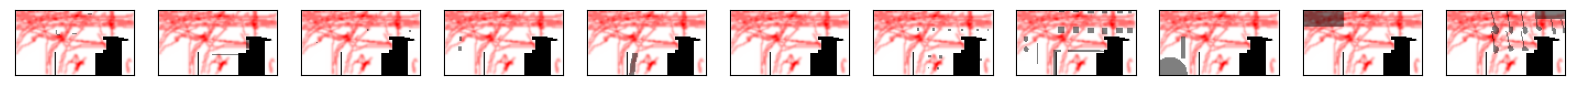

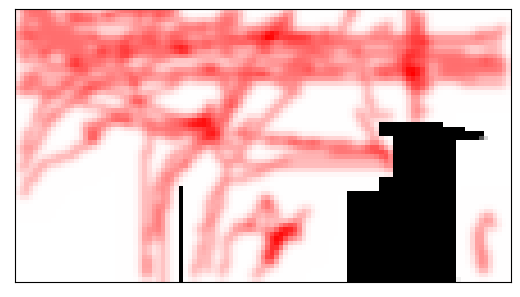

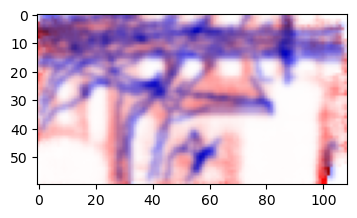

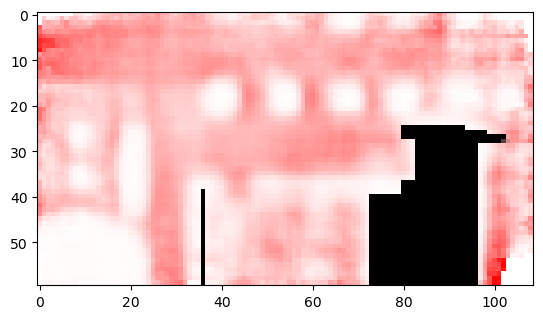

KL-divergence: 0.5407363176345825


SystemExit: 0

In [6]:
kl1 = []

for map_count, map_name in enumerate(map_list):
  print(map_name)

  args = get_args_parser()
  args = args.parse_args()

  args.resume = '/home/placido.falqueto/IRI_Barcelona/mae/output_dir/test5-checkpoint-100-'+map_name+'.pth'

  device = torch.device(args.device)

  # define the model
  model = models_mae.__dict__[args.model](norm_pix_loss=args.norm_pix_loss)

  model.to(device)

  model_without_ddp = model

  eff_batch_size = args.batch_size * args.accum_iter * misc.get_world_size()

  if args.lr is None:  # only base_lr is specified
      args.lr = args.blr * eff_batch_size / 256

  # following timm: set wd as 0 for bias and norm layers
  param_groups = optim_factory.add_weight_decay(model_without_ddp, args.weight_decay)
  optimizer = torch.optim.AdamW(param_groups, lr=args.lr, betas=(0.9, 0.95))
  loss_scaler = NativeScaler()

  misc.load_model(args=args, model_without_ddp=model_without_ddp, optimizer=optimizer, loss_scaler=loss_scaler)

  lines = 0
  try:
    with open('/home/placido.falqueto/IRI_Barcelona/maps/semantics/'+map_name+'/'+map_name+'-reduced.csv') as f:
      print('Reduced map found')
      lines = f.readlines()
      
  except FileNotFoundError:
    with open('/home/placido.falqueto/IRI_Barcelona/maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
      print('Using original map')
      lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  for lab_class in sem_dict:
    lines = 0
    try:
      with open('/home/placido.falqueto/IRI_Barcelona/maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'-reduced.csv') as f:
        lines = f.readlines()

      hh = len(lines)
      ww = len(lines[0].split(','))

      if hh != h or ww != w:
        print(f'h: {h}\tw: {w}')
        print(f'h: {hh}\tw: {ww}')
        raise SystemExit("ERROR: Different sizes!!")

      # Converts data to a list of integers
      for line in lines:
        map.extend([int(c) for c in line.split(',')])
    
    except FileNotFoundError:
      try:
        with open('/home/placido.falqueto/IRI_Barcelona/maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
          lines = f.readlines()

        hh = len(lines)
        ww = len(lines[0].split(','))

        if hh != h or ww != w:
          print(f'h: {h}\tw: {w}')
          print(f'h: {hh}\tw: {ww}')
          raise SystemExit("ERROR: Different sizes!!")

        # Converts data to a list of integers
        for line in lines:
          map.extend([int(c) for c in line.split(',')])

      except FileNotFoundError:
        for i in range(h):
          for j in range(w):
            map.extend([255])

  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/red)),int(math.ceil(w/red)),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red,red), np.max)

  # print(map.shape)
  h, w, _ = map.shape

# -----------------------------------------------------------------------------------
  lines = 0
  with open('/home/placido.falqueto/IRI_Barcelona/maps/semantics/'+map_name+'/humandensity-'+map_name+'-new.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([int(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  sigma = 10.0
  # data = skimage.filters.gaussian(data, sigma=(sigma, sigma), channel_axis=-1)
  data = skimage.measure.block_reduce(data, (red,red), np.max)
  # data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))
  data = data*(map[:,:,0]>0)

  sigma = 0.7
  data_show = data
  # data_show = cv2.LUT((data_show*255).astype(np.uint8), lut_8u).astype(np.float32)/255
  data_show = skimage.filters.gaussian(data_show, sigma=(sigma, sigma), channel_axis=-1)
  data_show = skimage.filters.gaussian(data_show, sigma=(sigma, sigma), channel_axis=-1)
  data = data_show/np.sum(data_show)
  data_show = data_show/np.max(data_show)

  # print(data.shape)
  hd, wd = data.shape

  print(sem_dict)
  plt.figure(figsize=(20,5))
  for i in range(len(sem_dict)):
    ax = plt.subplot(1, len(sem_dict), i+1)
    alp = 0.5
    ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2),np.multiply(np.stack((map[:,:,i+1],map[:,:,i+1],map[:,:,i+1]),axis=2)*alp+(1-alp), np.stack((np.full(data_show.shape,1),1-data_show,1-data_show),axis=2))), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

  ax = plt.subplot(111)
  ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_show.shape,1),1-data_show,1-data_show),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  # -----------------------------------------------------------------------------------
  # Random sample 32x32 windows in map
  n_crops = 500
  inserted = 0
  crops = np.zeros((n_crops,2),dtype=int)
  selections = np.zeros((h,w))
  for i in range(n_crops):
    background = np.zeros((h,w))
    flag = True
    while flag:
      aux_x = int(random.random()*(w-div+1))
      aux_y = int(random.random()*(h-div+1))
      flag = False
      # print(f'INSERTED: {inserted}  ->  x: {aux_x} and y: {aux_y}')
      # for z in range(inserted):
      #   if abs(aux_x-crops[z,0])<int(div/10) and abs(aux_y-crops[z,1])<int(div/10):
      #     # print('too close')
      #     flag = True
    crops[i,0] = aux_x
    crops[i,1] = aux_y
    selections = selections+cv2.rectangle(background,(crops[i,0],crops[i,1]),(crops[i,0]+div-1,crops[i,1]+div-1),(1,1,1),-1)
    inserted = inserted + 1
  selections = 1/selections

  # -----------------------------------------------------------------------------------
  # creating subplot and figure
  # ax = plt.subplot(111)
  data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))
  kls = []
  for i in range(n_crops):
    submap = map[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div,:]
    data_aux = data[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    submap = torch.tensor(np.expand_dims(submap,axis=0), dtype=torch.float32).to(device)
    _, subdata, _ = model(submap)
    subdata = torch.einsum('nchw->nhwc', subdata).detach().cpu()
    subdata = subdata.squeeze(dim=0).squeeze(dim=2).numpy()
    data_pred[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    # # Calculate the KL-divergence
    # data_aux = torch.Tensor(data_aux/np.sum(data_aux))
    # subdata_pred = torch.Tensor(subdata/np.sum(subdata))
    # kl = torch.nn.functional.kl_div(subdata_pred, data_aux, reduction='mean', log_target=True).item()
    # kls.append(kl)

  data = torch.Tensor(data)
  data_pred = torch.Tensor(data_pred)
  data = data/data.sum()
  data_pred = data_pred/data_pred.sum()
  data_pred[data_pred == 0] = 1e-12
  data_pred[data_pred == 1] = 1-1e-12
  data[data == 0] = 1e-12
  data[data == 1] = 1-1e-12

  kl = torch.nn.functional.kl_div(data_pred.unsqueeze(0).log(), data.unsqueeze(0), reduction='batchmean').item()

  data = data/data.max()
  data_pred = data_pred/data_pred.max()
  plt.figure(figsize=(4,4))
  plt.imshow(np.multiply(np.stack((1-data,1-data,np.full(data.shape,1)),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)))
  plt.show()
  
  data_pred = data_pred/np.max(data_pred.detach().cpu().numpy())
  plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  print(f'KL-divergence: {kl}')
  # # print(f'KL-divergences: {kls}')
  # print(f'KL-divergence average: {np.average(kls)}')
  # print(f'KL-divergence std: {np.std(kls)}')
  kl1 = np.append(kl1,kl)

print('-----------------------------')
print(f'Mean KL-divergence: {np.mean(kl1)}')
print(f'Std KL-divergence: {np.std(kl1)}')